<a href="https://colab.research.google.com/github/serikkk84/practicum/blob/main/final%20_project/%D0%BE%D1%82%D1%82%D0%BE%D0%BA%20%D0%BA%D0%BB%D0%B8%D0%B5%D0%BD%D1%82%D0%BE%D0%B2%20%D0%BE%D0%BF%D0%B5%D1%80%D0%B0%D1%82%D0%BE%D1%80%D0%B0%20%D1%81%D0%B2%D1%8F%D0%B7%D0%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Отток клиентов

Итак, нам поставлена задача обучить модель, прогнозирующую отток клиентов оператора связи «Ниединогоразрыва.ком», с целью сохранения лояльности таких клиентов путем предоставления им специальных промокодов и условий. Для решения задачи компания предоставила данные по клиентам по состоянию на 1 февраля 2020 года. Необходимым условием при обучении модели является получение метрики AUC-ROC не менее 0,75. 

Поставленная задача понятна. Для решения разделим ее на три этапа:

1. Загрузка и первичный анализ данных. Построение плана исследования.
2. Обучение не менее 3 различных моделей и поиск наилучших гиперпараметров.
3. В случае получения необходимой метрики, составление отчета о проделанной работе для передачи его в компанию.

## Этап загрузки и первичного анализа

### Загрузка данных

Первым делом загрузим необходимые библиотеки

In [ ]:
!pip install phik

     |████████████████████████████████| 679 kB 1.2 MB/s eta 0:00:01


In [ ]:
# pip install shap


In [ ]:
!pip install lightgbm

In [ ]:
import pandas as pd
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import matplotlib.pyplot as plt

import phik
from phik.report import plot_correlation_matrix
from phik import report

from sklearn.model_selection import train_test_split

from sklearn.model_selection import GridSearchCV
from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import roc_auc_score
import numpy as np
from sklearn.utils import shuffle
from lightgbm import LGBMClassifier

from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler
)

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc


Список загрузок будет пополняться по ходу исследования

#### Загрузим первый фаил.

In [ ]:
try:
    contract = pd.read_csv('/datasets/final_provider/contract.csv')
except:
    contract = pd.read_csv('contract.csv')
contract

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65
...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,No,One year,Yes,Mailed check,84.80,1990.5
7039,2234-XADUH,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7362.9
7040,4801-JZAZL,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,346.45
7041,8361-LTMKD,2019-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Mailed check,74.40,306.6


In [ ]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


В первом же файле мы получили целевой признак в колонке 'EndDate'. Тип данных object, следовательно будем обрабатывать данные целевого признака. Так же, думаю, надо будет поменять тип данных для столбцов 'BeginDate' и 'TotalCharges'.

Другие колонци содержат категоральные данные, их так же для некоторых моделей будем кодировать.

Посмотрим на дисбаланс классов по целевому признаку

In [ ]:
contract.query('EndDate == "No"').count()

customerID          5174
BeginDate           5174
EndDate             5174
Type                5174
PaperlessBilling    5174
PaymentMethod       5174
MonthlyCharges      5174
TotalCharges        5174
dtype: int64

Действительно дисбаланс имеется, а именно количество клиентов прекративших взаимоотношения с компанией составляет чуть менне трети от числа оставшихся лояльными. Держим дисбаланс на заметке, возможно, придется апсемплить базу.

Ну и на всякий случай посмотрим уникальные значения в столбцах с категоральными данными

In [ ]:
contract['Type'].unique()

array(['Month-to-month', 'One year', 'Two year'], dtype=object)

In [ ]:
contract['PaperlessBilling'].unique()

array(['Yes', 'No'], dtype=object)

In [ ]:
contract['PaymentMethod'].unique()

array(['Electronic check', 'Mailed check', 'Bank transfer (automatic)',
       'Credit card (automatic)'], dtype=object)

Данные не содержат вбросов и аномалий, готовы к кодировке и обучению

#### Второй фаил

In [ ]:
try:
    personal = pd.read_csv('/datasets/final_provider/personal.csv')
except:
    personal = pd.read_csv('personal.csv')
personal

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes
7039,2234-XADUH,Female,0,Yes,Yes
7040,4801-JZAZL,Female,0,Yes,Yes
7041,8361-LTMKD,Male,1,Yes,No


In [ ]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


Здесь мы видим данные по каждому клиенту. Количество строк совпадает с первым файлом, что логично, а также обе базы имеют общую колонку 'customerID' что позволит нам объединить данные.

Состав данных понятен. В основном категоральные. Будем кондировать.

На всякий случай убедимся, что нет аномалий.

In [ ]:
personal['gender'].unique()

array(['Female', 'Male'], dtype=object)

In [ ]:
personal['SeniorCitizen'].unique()

array([0, 1])

In [ ]:
personal['Partner'].unique()

array(['Yes', 'No'], dtype=object)

In [ ]:
personal['Dependents'].unique()

array(['No', 'Yes'], dtype=object)

Данные готовы к работе.

Посмотрим распределение клиентов по категориям. В этом нет пока никакой необходимости. Просто интересно

<AxesSubplot:xlabel='gender', ylabel='count'>

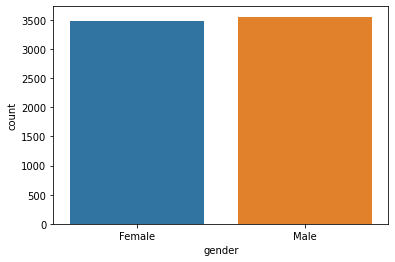

In [ ]:
sns.countplot(personal.gender)

<AxesSubplot:xlabel='Partner', ylabel='count'>

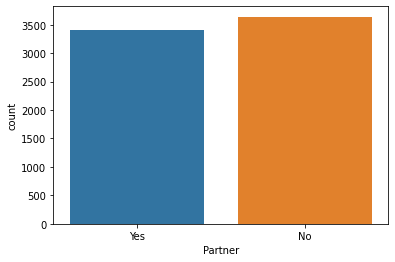

In [ ]:
sns.countplot(personal.Partner)

<AxesSubplot:xlabel='Dependents', ylabel='count'>

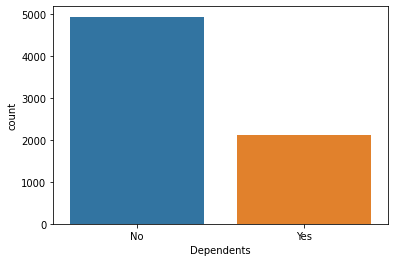

In [ ]:
sns.countplot(personal.Dependents)

<AxesSubplot:xlabel='SeniorCitizen', ylabel='count'>

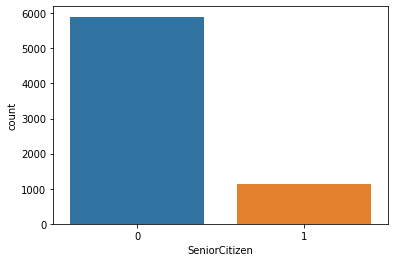

In [ ]:
sns.countplot(personal.SeniorCitizen)

Мужчин и женщин среди клиентов компании примерно поровну, как и клиентов состоящих и несостоящих в отношениях с партнером. В то же время, пенсионеров примерно в пять раз меньше, чем работающих. Так же, среди клиентгов компании большую часть составляют те у кого нет иждевенцев. Соотношение примерно три к одному. 

#### Третий фаил

In [ ]:
try:
    internet = pd.read_csv('/datasets/final_provider/internet.csv')
except:
    internet = pd.read_csv('internet.csv')
internet

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...
5512,6840-RESVB,DSL,Yes,No,Yes,Yes,Yes,Yes
5513,2234-XADUH,Fiber optic,No,Yes,Yes,No,Yes,Yes
5514,4801-JZAZL,DSL,Yes,No,No,No,No,No
5515,8361-LTMKD,Fiber optic,No,No,No,No,No,No


In [ ]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


В этом файле мы видим информацию о пользователях услугами интернет. Фаил так же содержитстолбец 'customerID', что позволит объеденить его с двумя предыдущими, однако, здесть меньше строк, что говорит о том, что не все клиенты пользуются услугами internet. При объединении получим пропуски, будем заполнять .

Проверим на аномалии.

In [ ]:
internet['InternetService'].unique()

array(['DSL', 'Fiber optic'], dtype=object)

In [ ]:
internet['OnlineSecurity'].unique()

array(['No', 'Yes'], dtype=object)

In [ ]:
internet['OnlineBackup'].unique()

array(['Yes', 'No'], dtype=object)

In [ ]:
internet['DeviceProtection'].unique()

array(['No', 'Yes'], dtype=object)

In [ ]:
internet['TechSupport'].unique()

array(['No', 'Yes'], dtype=object)

In [ ]:
internet['StreamingTV'].unique()

array(['No', 'Yes'], dtype=object)

In [ ]:
internet['StreamingMovies'].unique()

array(['No', 'Yes'], dtype=object)

Данные готовы к работе

#### Четвертый фаил

In [ ]:
try:
    phone = pd.read_csv('/datasets/final_provider/phone.csv')
except:
    phone = pd.read_csv('phone.csv')
phone

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes
...,...,...
6356,2569-WGERO,No
6357,6840-RESVB,Yes
6358,2234-XADUH,Yes
6359,8361-LTMKD,Yes


In [ ]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


В этом файле мы видим данные о пользователях телефонными услугами. Так же есть возможность для объединения данных по id.

Проверим уникальные значения.

In [ ]:
phone['MultipleLines'].unique()

array(['No', 'Yes'], dtype=object)

Данные готовы к работе

### Вывод по первому этапу

Данные загружаются и читаются. На первом этапе пропуски отсутствуют, однако появяться на этапе слияния данных. Некоторые столбцы нуждаются в обработке, а именно в смене типа данных. Так же не забываем об обработке данных целевого признака, а именно замене дат расторжения договоров на категорию 'Yes'. 

Перед переходом ко второму этапу составим примерный план дальнейших действий.

### Вопросы по  первому этапу

1. Что важнее для заказчика: скорость обучения модели, скорость предсказания или качество итоговой метрики?

## План второго этапа.

1. Изменение типов данных некоторых столбцов в первом датафрейме и обработка данных целевого признака.
2. Слияние таблиц. 
3. Работа с пропусками в новой таблице.
4. Поиск и удаление данных, которые могут привести к утечке данных, методом корреляции.
5. Разделение датафрейма на тренировочную и тестовую выборку.
6. Создание копии общей базы для кодирования в ней категоральных признаков для некоторых моделей.
7. Обучение модели дерева решений и поиск лучших гиперпараметров для нее.
8. Обучение модели случайного леса и поиск лучших гиперпараметров для нее.
9. Обучение линейной модели и поиск лучших гиперпараметров для нее.
10. Обучение модели градиентного бустинга и поиск лучших гиперпараметров для нее.
11. Объединение полученных данных в таблицу и выбор лучшей модели для ее последующего тестирования.

## Этап второй. Обучение моделей.

### Обработка данных

Начнем с целевого признака. В столбце 'EndDate' мы имеем либо значение 'No', что означает продолжение сотрудничества клиента с компанией, либо дату расторжения договора в формате object. Заменим значение на 0 - клиент продолжает сотрудничество, и 1 - договор расторгнут

In [ ]:
contract['target'] = ''
contract.loc[contract['EndDate'] != 'No', 'target'] = 1
contract.loc[contract['EndDate'] == 'No', 'target'] = 0

contract

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,target
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,0
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,1
...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,No,One year,Yes,Mailed check,84.80,1990.5,0
7039,2234-XADUH,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7362.9,0
7040,4801-JZAZL,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,346.45,0
7041,8361-LTMKD,2019-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Mailed check,74.40,306.6,1


И проверим полученные данные на уникальность

In [ ]:
contract['target'].unique()

array([0, 1], dtype=object)

Теперь заменими типы данных в столбцах 'BeginDate' и 'TotalCharges' на date и float соответственно

In [ ]:
contract['BeginDate'] = pd.to_datetime(contract['BeginDate'])

#contract['BeginDate'].info()

In [ ]:
contract['TotalCharges'] = pd.to_numeric(contract['TotalCharges'], errors='coerce') 
#contract['TotalCharges'].info()

С датами получилось все корректно, а вот в колонке 'TotalCharges' мы не смогла перевести 11 значений в числовой формат. Думаю, можно удалить эти строки после слияния таблиц

### Слияние таблиц

Объединим все таблицы в единый датафрейм методом merge. За исходную базу возьмем фаил contract, так как он содержит все данные по всем договорам. Присоединять будем по колонке 'customerID', так как она является общей для всех файлов.

In [ ]:
data = contract.merge(personal, on='customerID', how='left')
data

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,target,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,0,Female,0,Yes,No
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,0,Male,0,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,1,Male,0,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,0,Male,0,No,No
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,1,Female,0,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,No,One year,Yes,Mailed check,84.80,1990.50,0,Male,0,Yes,Yes
7039,2234-XADUH,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7362.90,0,Female,0,Yes,Yes
7040,4801-JZAZL,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,346.45,0,Female,0,Yes,Yes
7041,8361-LTMKD,2019-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Mailed check,74.40,306.60,1,Male,1,Yes,No


In [ ]:
data = data.merge(internet, on='customerID', how='left')

In [ ]:
data = data.merge(phone, on='customerID', how='left')

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   object        
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
 8   target            7043 non-null   object        
 9   gender            7043 non-null   object        
 10  SeniorCitizen     7043 non-null   int64         
 11  Partner           7043 non-null   object        
 12  Dependents        7043 non-null   object        
 13  InternetService   5517 non-null   object        
 14  OnlineSecurity    5517 n

Удалим 11 строк с некорректными данными в колонке 'TotalCharges'

In [ ]:
data['TotalCharges'] = data['TotalCharges'].fillna('0')
data.drop(data[data.TotalCharges == '0'].index, inplace=True)


Заполним пропуски значением 'No', так как пропуски в новой таблице означают, что клиент просто не пользуется услугами интернета или телефонии

In [ ]:
data = data.fillna('No')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7032 non-null   object        
 1   BeginDate         7032 non-null   datetime64[ns]
 2   EndDate           7032 non-null   object        
 3   Type              7032 non-null   object        
 4   PaperlessBilling  7032 non-null   object        
 5   PaymentMethod     7032 non-null   object        
 6   MonthlyCharges    7032 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
 8   target            7032 non-null   int64         
 9   gender            7032 non-null   object        
 10  SeniorCitizen     7032 non-null   int64         
 11  Partner           7032 non-null   object        
 12  Dependents        7032 non-null   object        
 13  InternetService   7032 non-null   object        
 14  OnlineSecurity    7032 n

И снова тип столбца 'TotalCharges' стал object. Заменим

In [ ]:
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce') 
#data['TotalCharges'].info()

Так же можно удалить колонку 'customerID', так как она больше не нужна

In [ ]:
data = data.drop(['customerID'], axis=1)

### Проверка корреляций

Перед проверкой корреляции создадим новый признак - длительность контракта в днях. Для этого значения 'No' в столбце 'EndDate' заменим датой составления фрейма, а именно 1 февраля 2020 года.  

In [ ]:
data.loc[data['EndDate'] == 'No', 'EndDate'] = '2020-02-01'
data['EndDate'] = pd.to_datetime(data['EndDate'])
data['duration'] =(data['EndDate'] - data['BeginDate']) / np.timedelta64 ( 1 , 'D')
data

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,target,gender,SeniorCitizen,...,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,duration
0,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,0,Female,0,...,No,DSL,No,Yes,No,No,No,No,No,31.0
1,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.50,0,Male,0,...,No,DSL,Yes,No,Yes,No,No,No,No,1036.0
2,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,1,Male,0,...,No,DSL,Yes,Yes,No,No,No,No,No,61.0
3,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75,0,Male,0,...,No,DSL,Yes,No,Yes,Yes,No,No,No,1371.0
4,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,1,Female,0,...,No,Fiber optic,No,No,No,No,No,No,No,61.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,2018-02-01,2020-02-01,One year,Yes,Mailed check,84.80,1990.50,0,Male,0,...,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,Yes,730.0
7039,2014-02-01,2020-02-01,One year,Yes,Credit card (automatic),103.20,7362.90,0,Female,0,...,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Yes,2191.0
7040,2019-03-01,2020-02-01,Month-to-month,Yes,Electronic check,29.60,346.45,0,Female,0,...,Yes,DSL,Yes,No,No,No,No,No,No,337.0
7041,2019-07-01,2019-11-01,Month-to-month,Yes,Mailed check,74.40,306.60,1,Male,1,...,No,Fiber optic,No,No,No,No,No,No,Yes,123.0


In [ ]:
data = data.drop(['BeginDate', 'EndDate'], axis=1)

Проверим уровень корреляции целевого признака с другими данными с целью избежать его утечки при обучении

interval columns not set, guessing: ['MonthlyCharges', 'TotalCharges', 'target', 'SeniorCitizen', 'duration']


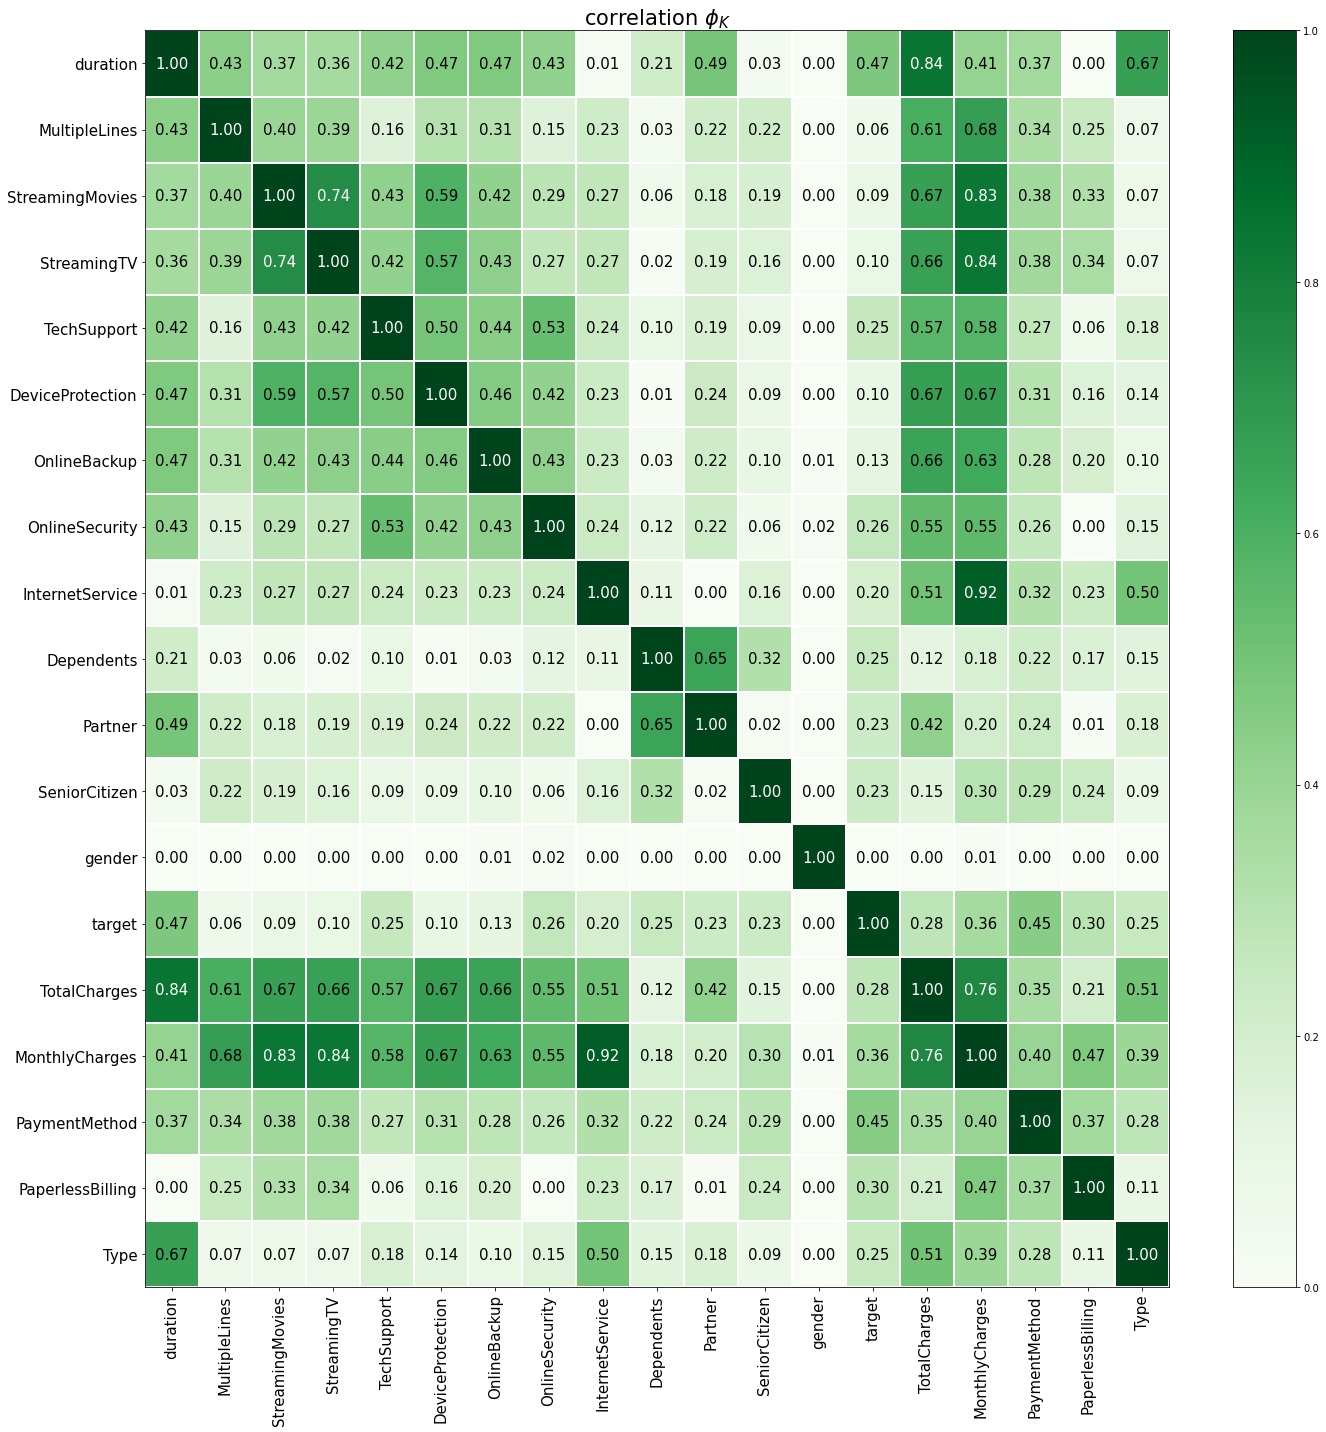

In [ ]:
phik_overview = data.phik_matrix()
phik_overview.round(2)
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1.5, 
                        figsize=(20, 20))
plt.tight_layout()

### Разделелие датафрейма

Разделим базу данных на обучающую и тестовою

In [ ]:
y = data['target']
X = data.drop('target', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y,stratify=y, test_size=0.25, random_state=121222)


### Кодирование признаков

Проведем кодирование признаков методом OrdinalEncoder для бустинга и деревьев. Для этого создадим копию датафрейма.

In [ ]:
num_features = X_train.select_dtypes(exclude='object').columns.to_list()
num_features

['MonthlyCharges', 'TotalCharges', 'SeniorCitizen', 'duration']

In [ ]:
#data_ord_enc = data.copy()scaler = StandardScaler()
object_features = X_train.select_dtypes(include='object').columns.to_list()
object_features

['Type',
 'PaperlessBilling',
 'PaymentMethod',
 'gender',
 'Partner',
 'Dependents',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'MultipleLines']

In [ ]:
scaler = StandardScaler()
X_train_stand = X_train.copy()
X_train_stand[num_features] = scaler.fit_transform(X_train[num_features])
X_train_stand

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,duration
4862,Month-to-month,Yes,Electronic check,0.211394,-0.945526,Female,-0.440787,No,No,Fiber optic,No,No,No,No,No,No,No,-1.243106
1367,Month-to-month,Yes,Electronic check,0.584212,1.163702,Male,2.268668,Yes,No,Fiber optic,No,Yes,No,No,No,No,Yes,1.163379
6969,Month-to-month,No,Mailed check,-1.467950,-0.997495,Male,-0.440787,No,No,No,No,No,No,No,No,No,No,-1.284643
932,Two year,No,Credit card (automatic),-1.507895,-0.429226,Male,-0.440787,Yes,No,No,No,No,No,No,No,No,No,1.610910
1469,Month-to-month,No,Bank transfer (automatic),1.138445,0.531274,Male,-0.440787,No,No,Fiber optic,No,No,No,Yes,Yes,Yes,Yes,0.183902
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2757,One year,No,Bank transfer (automatic),0.660773,1.581287,Female,-0.440787,Yes,Yes,Fiber optic,Yes,No,Yes,No,No,No,Yes,1.491657
2443,Two year,No,Credit card (automatic),1.496284,2.483336,Female,-0.440787,Yes,Yes,Fiber optic,Yes,Yes,Yes,No,Yes,Yes,Yes,1.610910
2596,One year,Yes,Credit card (automatic),-0.191382,-0.468761,Female,-0.440787,Yes,Yes,DSL,No,Yes,No,No,Yes,No,No,-0.465956
6091,Month-to-month,Yes,Mailed check,0.740662,-0.937385,Male,2.268668,Yes,No,Fiber optic,No,No,No,No,Yes,No,Yes,-1.243106


In [ ]:
X_test_stand = X_test.copy()
X_test_stand[num_features] = scaler.transform(X_test[num_features])

 Теперь кодирование.

In [ ]:
ord_enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X_train_ord_enc = ord_enc.fit_transform(X_train[object_features])


Для линейных моделей создадим отделный фрейм с прямым кодированием категоральных данных

In [ ]:
X_train_ohe = pd.get_dummies(X_train_stand, drop_first=True)
X_test_ohe = pd.get_dummies(X_test_stand, drop_first=True)

X_train_ohe


,MonthlyCharges,TotalCharges,SeniorCitizen,duration,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,...,Dependents_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,MultipleLines_Yes
4862,0.211394,-0.945526,-0.440787,-1.243106,0,0,1,0,1,0,...,0,1,0,0,0,0,0,0,0,0
1367,0.584212,1.163702,2.268668,1.163379,0,0,1,0,1,0,...,0,1,0,0,1,0,0,0,0,1
6969,-1.467950,-0.997495,-0.440787,-1.284643,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0
932,-1.507895,-0.429226,-0.440787,1.610910,0,1,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
1469,1.138445,0.531274,-0.440787,0.183902,0,0,0,0,0,0,...,0,1,0,0,0,0,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2757,0.660773,1.581287,-0.440787,1.491657,1,0,0,0,0,0,...,1,1,0,1,0,1,0,0,0,1
2443,1.496284,2.483336,-0.440787,1.610910,0,1,0,1,0,0,...,1,1,0,1,1,1,0,1,1,1
2596,-0.191382,-0.468761,-0.440787,-0.465956,1,0,1,1,0,0,...,1,0,0,0,1,0,0,1,0,0
6091,0.740662,-0.937385,2.268668,-1.243106,0,0,1,0,0,1,...,0,1,0,0,0,0,0,1,0,1


### Обучение моделей

Создадим фрейм для объедеинения результатов обучения

In [ ]:
models = pd.DataFrame(columns=['Model', 'ROC_AUC'])
def metrics(model_name, roc_auc, df):
    
    df.loc[model_name,'Model'] = model_name
    df.loc[model_name,'ROC_AUC'] = roc_auc
    
    return df

#### CatBoostClassifier

In [ ]:
CBC = CatBoostClassifier(random_state=121222, auto_class_weights  = 'Balanced')
parameters = {'depth': [1, 2, 3],
              'learning_rate' : [0.4 , 0.5],
              'iterations'    : [80, 90, 100],
                               }

In [ ]:
grid = GridSearchCV(estimator=CBC, param_grid = parameters, cv = 3, n_jobs=-1, scoring='roc_auc')
grid.fit(X_train_ord_enc, y_train)
print("best parameters ", grid.best_params_)
print("roc_auc :", grid.best_score_)
metrics('CatBoostClassifier', grid.best_score_, models)

 Проверим CatBoost на необработанных данных, без масштабирования. Категоральные признаки передадим через параметр 'cat_features'.</div>

In [ ]:
grid_unprepeared = GridSearchCV(estimator=CBC, param_grid = parameters, cv = 3, n_jobs=-1, scoring='roc_auc')
cat_features = ['Type', 'PaperlessBilling', 'PaymentMethod',  'gender', 'Partner', 'Dependents',
             'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
              'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines']

grid_unprepeared.fit(X_train, y_train, cat_features=cat_features)
print("best parameters ", grid_unprepeared.best_params_)
print("roc_auc :", grid_unprepeared.best_score_)
metrics('CatBoostClassifier_unprepeared', grid_unprepeared.best_score_, models)

#### DecisionTreeClassifier

In [ ]:
params = {'max_leaf_nodes': list(range(2, 100)), 'min_samples_split': [2, 3, 4, 5, 6, 7, 8]}
grid_search_cv = GridSearchCV(DecisionTreeClassifier(random_state=121222), params, verbose=1, cv=4, scoring='roc_auc')
grid_search_cv.fit(X_train_ord_enc, y_train)
print("best parameters ", grid_search_cv.best_params_)
print("roc_auc :", grid_search_cv.best_score_)
metrics('DecisionTreeClassifier', grid_search_cv.best_score_, models)

Fitting 4 folds for each of 686 candidates, totalling 2744 fits
best parameters  {'max_leaf_nodes': 16, 'min_samples_split': 2}
roc_auc : 0.8095781690952146


,Model,ROC_AUC
CatBoostClassifier,CatBoostClassifier,0.828003
CatBoostClassifier_unprepeared,CatBoostClassifier_unprepeared,0.878732
DecisionTreeClassifier,DecisionTreeClassifier,0.809578


#### LogisticRegression

In [ ]:
grid_log_reg={"C":np.logspace(-4, 4, 15), "penalty":["l1", "l2", "none", 'elasticnet'], 
              "class_weight" : [None, 'balanced'], "solver" : ['liblinear', 'lbfgs'],                                                          
              "multi_class" : ['auto', 'ovr', 'multinomial']}
logreg=LogisticRegression(random_state=121222,)
logreg_cv=GridSearchCV(logreg, grid_log_reg, cv=3, scoring='roc_auc')
logreg_cv.fit(X_train_ohe, y_train)

print("best parameters ", logreg_cv.best_params_)
print("roc_auc :", logreg_cv.best_score_)
metrics('LogisticRegression', logreg_cv.best_score_, models)

#### Анализ полученных результатов

Посмотрим данные общей таблицы и выберем лучшую модель

In [ ]:
models

,Model,ROC_AUC
CatBoostClassifier,CatBoostClassifier,0.828003
CatBoostClassifier_unprepeared,CatBoostClassifier_unprepeared,0.878732
DecisionTreeClassifier,DecisionTreeClassifier,0.809578
LogisticRegression,LogisticRegression,0.846528


Лучшей моделью стала CatBoostClassifier_unprepeared	 с метрикой ROC-AUC равной 0.878732 на тренировочной выборке.

#### Проверка на тествой выборке

In [ ]:

test_predict = grid_unprepeared.predict_proba(X_test)
test_predict = test_predict[:, 1]
print("roc_auc на тестовой выборке:", roc_auc_score(y_test, test_predict))

roc_auc на тестовой выборке: 0.894889176758219


Оценим важность признаков.

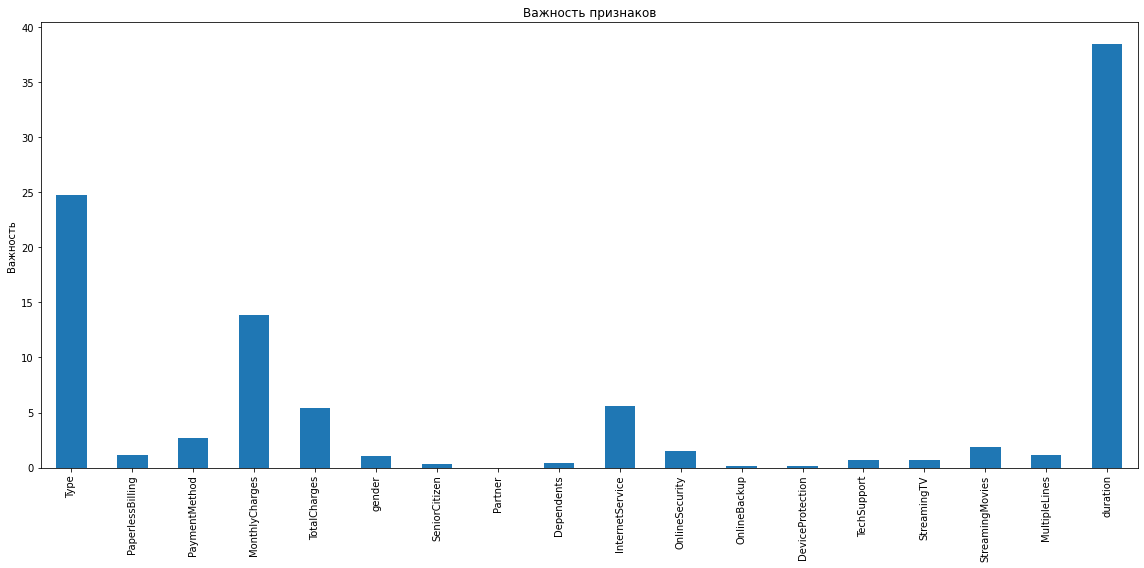

In [ ]:
importance = pd.Series(grid_unprepeared.best_estimator_.feature_importances_,
                         data.drop(['target'], axis=1).columns)


fig, ax = plt.subplots(figsize=(16,8))
importance.plot.bar(ax=ax)
ax.set_title("Важность признаков")
ax.set_ylabel('Важность')
fig.tight_layout()


Построим график ROC-кривой.

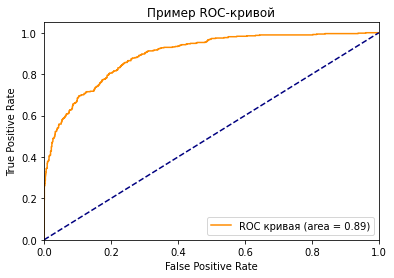

In [ ]:
fpr, tpr, treshold = roc_curve(y_test, test_predict)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Пример ROC-кривой')
plt.legend(loc="lower right")
plt.show()

 И посмотрим на матрицу ошибок.

In [ ]:
confusion_matrix(y_test, test_predict.round())

array([[1012,  279],
       [  85,  382]])

 Впринципе, матрица ошибок показывает, что предсказания в большей части корректны. Программа правильно предсказала 1012 клиента, которые остались и 382 клиентов которые ушли. 85 раз программа ошибочно предсказала, что клиент останется. Много, возможно, если изменить порог AUC-ROC и снизить число FALSE NEGATIVE, компания сможет путем предоставления клиентам доп опции сохранит  лояльность клиентов. 

## Отчет об исследовании

### Цель исследования

Итак, перед нашим отделом была поставлена задача разаработать и обучить в течении двух недель модель, способную предсказывать отток клиентов телекомоператора «Ниединогоразрыва.ком» с требуемым качеством по метрике ROC-AUC > 0.85, с целью сохранения лояльности таких клиентов путем предоставления телекомоператором им специальных промокодов и условий.

### Загрузка данных и составление плана

На первом этапе я ознакомился с предоставленными телекомоператором данными, а именно 4 файла с информацией по состоянию на 1 февраля 2020 года, включающие в себя:
1. contract - фаил содержащий информацию о конирактах с клиентами, включающий информацию о дате заключения и расторжения договора, способах оплаты, а так же ежемесячных и ежегодных платежах. Безусловно, фаил содержит важнейшую информацию, включая целевой признак - столбец 'EndDate' с информацией о дате расторжения контракта, либо значением 'No' если клиент продолжает сотрудничество с компанией.
2. personal - информация о клиентах банка, такая как пол, статус пенсионера, наличие иждевенцев и прочее.
3. phone и internet -информация об услугах, предоставляемых телекомоператором, такие как наличие выделенной линии, стриминговые сервисы или многоканальная телефония.

Первоначальная загрузка и предварительный анализ показали, что данные полные, не содержат пропусков или некорректных данных. Кроме того, внимание привлекло то, что файлы phone и internet, содержат отличное от первого датасета количество строк, что логично, так как некоторые клиенты просто не используют некоторые из услуг.

Также был составлен предвварительный план исследования, включающий в себя следующие пункты:
1. Изменение типов данных некоторых столбцов в первом датафрейме и обработка данных целевого признака.
2. Слияние таблиц. 
3. Работа с пропусками в новой таблице.
4. Поиск и удаление данных, которые могут привести к утечке данных, методом корреляции.
5. Разделение датафрейма на тренировочную и тестовую выборку.
6. Создание копии общей базы для кодирования в ней категоральных признаков для некоторых моделей.
7. Обучение модели дерева решений и поиск лучших гиперпараметров для нее.
8. Обучение модели случайного леса и поиск лучших гиперпараметров для нее.
9. Обучение линейной модели и поиск лучших гиперпараметров для нее.
10. Обучение модели градиентного бустинга и поиск лучших гиперпараметров для нее.
11. Объединение полученных данных в таблицу и выбор лучшей модели для ее последующего тестирования.

### Вополнение шагов согласно плану.

1. Некоторые столбцы датафреймов имели тип данных не соответствующий содержанию. Тип данных был изменен, например в колонке 'BeginDate'  с типа object на datetime, а в колонке 'TotalCharges' на тип float. Уже на этом этапе столкнулся с проблемой, 11 строк в столбце 'TotalCharges' не были обработаны и были пропущение параметром 'coerce'. Мною было принято решение просто удалить эти строки так как они составляют ничтножно малую долю от общего фрейма. Так же был выделен целевой признак в отдельную колонку 'target' со значениями 1-клиент ушел и 0-клиент продолжает сотрудничество. Затем, по рекомендации тимлида мною был создан дополнительный признак duration, содержащий информацию о длительности контракта в днях.
2. Было произведено слияние таблиц методом merge по общей колонке 'customerID'.
3. Пропуски, полученные в результате присоединения таблиц phone и internet были заполнены значением 'No', что соответствует тому, что клиент просто не использовал данный тип услуг.
4. Проверка корреляции методом phik, показала, что сильных связей между данными нет и мы можем не опасаться утечки целевого признака. 
5. Разделил новую таблицу data на тренировочную и тестовую выборку (25%) методом train_test_split.
6. Создал копии тренировочных и тестовых выборок содержыщих признаки и провел кодирование их категоральных признаков методами OrdinalEncoder и get_dummies, а также масштабирование числовых данных методом StandardScaler, для разных моделей.
7. Создание функции для объединения в таблицу полученных результатов машинного обучения. Обучение CatBoostClassifier с использованием кросс-валидации для поиска лучших параметров с применением кодированных методом OrdinalEncoder категоральных признаков.
8. Обучение CatBoostClassifier_unprepeared с использованием кросс-валидации для поиска лучших параметров с применением некодированных признаков, с непосредственным их кодированием моделью, путем передачи списка категоральных признаков методом cat_features.
9. Обучение DecisionTreeClassifier с использованием кросс-валидации для поиска лучших параметров с применением кодированных методом OrdinalEncoder категоральных признаков.
10. Обучение LogisticRegression с использованием кросс-валидации для поиска лучших параметров с применениеммасштабирования числовых признаков и  кодированных методом get_dummies категоральных признаков.
11. Вывод таблицы с данными машинного обучения по всем моделям и выбор модели CatBoostClassifier_unprepeared, показавшей лучшии результат метрики ROC-AUC равной 0.878732.

In [ ]:
models

,Model,ROC_AUC
CatBoostClassifier,CatBoostClassifier,0.828003
CatBoostClassifier_unprepeared,CatBoostClassifier_unprepeared,0.878732
DecisionTreeClassifier,DecisionTreeClassifier,0.809578
LogisticRegression,LogisticRegression,0.846528


### Результат выполнения первоначального плана

По ходу исследования мною были выполнены все пункты плана за исключением обучения модели случайного леса, так как модель градиентного бустинга, показавшая хороший показатель метрики исследовалась первой, в то время как простые модели как дерево решении показали гораздо более низкий результат. Как результат, мною было принято исключить этот пункт с целью сохранения времени и ресурсов.

### Трудности

Наибольшей проблемой по ходу исследования стало отображение важности признаков лучшей модели. Причиной стало невозвможность напрямую использвать лучшую модель полученную при кросс-валидации grid_unpredicted с атрибутом feature_importances_, как это обычно делал ранее, использовав напрямую необходимую модель ML.

Проблема была решена при более детальном изучении документации grid_search, где я нашел необходимую информацию для построения гистограммы важности признаков, а именно атрибут grid_unprepeared.best_estimator_.feature_importances_.

### Проверка результата на тествой моделе

Лучшая модель CatBoostClassifier_unprepeared со следующими параметрами: 'depth': 3, 'iterations': 100, 'learning_rate': 0.5,  показала метрику roc_auc на тестовой выборке: 0.894889176758219, что соответствует минимальному требованию заказчика. 

Задача выполнена, однако, для полноты исследования мною была построена гистограмма важности признаков, ROC-кривая и матрица ошибок на основании которых для маркетологов «Ниединогоразрыва.ком» можно подготовить комплекс предложений, связанных с корректировкой порога вероятности, с целью еще сильнее улучшить метрику Recall и точнее предсказывать отточных клиентов.

### Ключевые шаги

На мой взгляд ключевыми шагами при исследовании стали:
1. Выделение синтетического признака duration, позволившего значительно улучшить показатель метрики, и который стал важнейшим признаком, что видно из гостограммы важности признаков

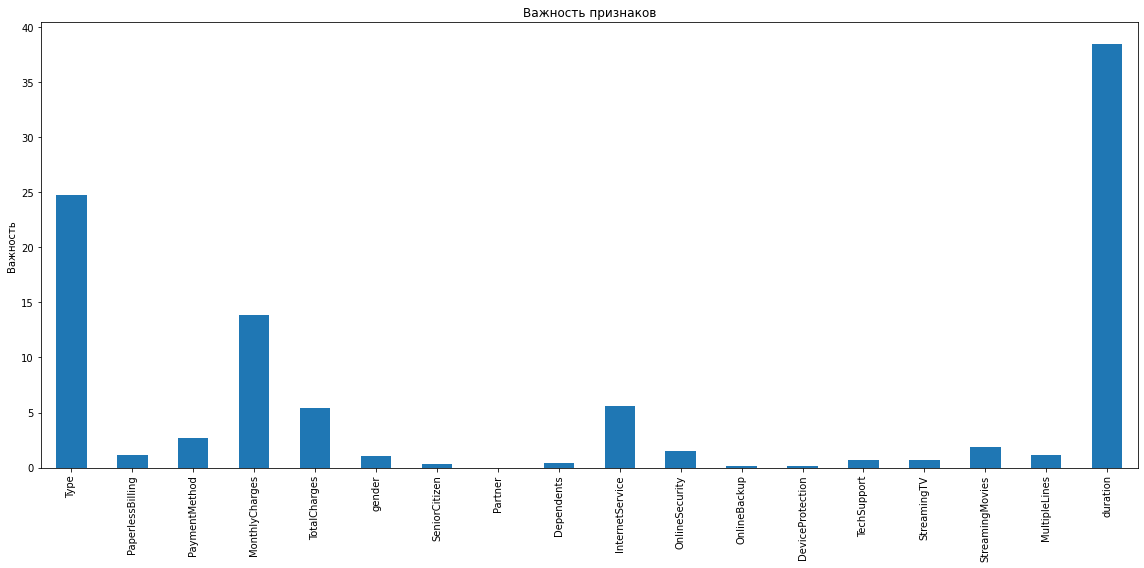

In [ ]:
fig, ax = plt.subplots(figsize=(16,8))
importance.plot.bar(ax=ax)
ax.set_title("Важность признаков")
ax.set_ylabel('Важность')
fig.tight_layout()

2. Использование кросс-валидации при поиске лучших гиперпараметров.
3. Использование для бустинга чистых(некодированных) категоральных данных и использование внутренних механизмов бустинга для их преобразования.